# Geo-Spatial Data and Interactive Visualizations Project

**Goal**

The goal is to explore geospatial data for Afghanistan (1999–2008) to understand relationships between droughts, conflicts and economic activity (nightlights). This notebook performs all data loading, cleaning, merging, exploratory analysis and finally builds an interactive dashboard using Dash and Plotly.

**Author**

Olga Ruiz.

**Date**

February 2026

## Index
This notebook will be used for initial testing, library loading, enviornment setup and the real analysis.

1. Setup and Libraries
2. Analysis Overview
3. Data Loading
4. Data Cleaning and Filtering
5. Geospatial Data Preparation
6. Data Integrity Check
7. Data Exploration and Descriptive Analysis (EDA)
8. Interactive Dashboard
9. Discussion

## 1. Setup and Libraries

In this notebook, we will work with geospatial data and create interactive visualizations. 
These are the main libraries used:

- **pandas**: for data manipulation and handling tabular datasets.
- **numpy**: for numerical operations and calculations.
- **geopandas**: for working with geospatial data such as shapefiles and geometry.
- **plotly.express**: for creating interactive charts and plots that can be linked with maps.
- **plotly.graph_objects**: for more customizable interactive plots.
- **plotly.subplots**:for creating grids of subplots within a single figure
- **dash**: for building interactive web applications and dashboards.
- **warnings**: to manage warning messages during analysis.

In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, Input, Output, ctx
import warnings

In [9]:
# plotly defauly settings
pio.templates.default = "simple_white"

# set Plotly renderer to "jupyterlab" to ensure all interactive charts display correctly within JupyterLab.
pio.renderers.default = "jupyterlab"

# centroid calculations in geographic CRS are fine for our purposes
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

## 2. Analysis Overview

The analysis focuses on 1999–2008, a period characterized by pronounced drought variability and corresponding fluctuations in conflict incidence. Night-time lights are used as a proxy for economic activity, which may mediate the drought–conflict relationship. Years after 2008 were excluded due to external geopolitical escalations that introduce confounding effects beyond the climatic scope of this study.

**Dataset Selection**

- Dataset: PRIO-GRID and UCDP Georeferenced Event Dataset (GED)
- Focus: Droughts, Conflicts, Nightlights
- Country: Afghanistan
- Year range: 1999-2008
- URL source: https://www.prio.org/data, https://ucdp.uu.se/downloads/

**Variables**

- `droughtcrop_speibase`: Drought intensity during growing season
- `conflicts`: Number of armed conflict events per cell per year
- `nlights_mean`: Light intensity at night (a proxy for economic activity)
- `pop_hyd_sum`: Population per cell

## 3. Data Loading

Loading datasets:
- PRIO-GRID CSV file
- GED CSV file
- PRIO-GRID shapefile 

In [13]:
# load PRIO-GRID CSV (climate, nightlights, population)
df_prio = pd.read_csv("data/PRIO-GRID_Yearly_Variables.csv")

# load GED CSV (conflict events) and disable low_memory to avoid dtype warnings
df_conflicts = pd.read_csv("data/GEDEvent_v25_1.csv", low_memory=False)

# load PRIO-GRID shapefile (cell geometries)
prio_shapes = gpd.read_file("data/priogrid_cellshp/priogrid_cell.shp")

## 4. Data Cleaning and Filtering

- Filter Afghanistan cells (`gwno = 700`)
- Filter 1999–2008
- Assign year 2000 population to all years per cell
- Keep only relevant columns

Note: Population data (pop_hyd_sum) is only available every 5 years. 
To include it in the analysis for all years (1999–2008), I assigned the year 2000 value to every row of each grid cell.

**PRIO-GRID file**

In [16]:
df_prio_afg = df_prio[(df_prio['gwno'] == 700) & (df_prio['year'] >= 1999) & (df_prio['year'] <= 2008)][['gid', 'year', 'droughtcrop_speibase', 'pop_hyd_sum', 'nlights_mean']].copy()

In [17]:
# assign year 2000 population to all years per cell
pop_2000_dict = df_prio_afg[df_prio_afg['year'] == 2000].set_index('gid')['pop_hyd_sum'].to_dict()
df_prio_afg['pop_hyd_sum'] = df_prio_afg['gid'].map(pop_2000_dict)

In [18]:
# quick test
df_prio_afg.head()

,gid,year,droughtcrop_speibase,pop_hyd_sum,nlights_mean
704081,172563,2000,NaN,9768.365,0.020000
704083,172563,2005,NaN,9768.365,0.051667
704088,172563,2003,NaN,9768.365,0.011667
704090,172563,2008,NaN,9768.365,0.041667
704095,172563,2006,NaN,9768.365,0.032222


**GED file**

In [20]:
# see all the columns in the file GED to keep the relevant ones
df_conflicts.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='str')

In [21]:
# filter
df_conflicts_clean = df_conflicts[(df_conflicts['country_id'] == 700) & (df_conflicts['year'].between(1999, 2008))][['priogrid_gid', 'year', 'country', 'country_id']].copy()

In [22]:
# check 
df_conflicts_clean.columns

Index(['priogrid_gid', 'year', 'country', 'country_id'], dtype='str')

**Merge PRIO and GED Datasets**

In [24]:
# show columns and check that 'gid' in PRIO-GRID and 'priogrid_gid' in GED match and have the same data type
print(df_prio_afg.columns)
print(df_conflicts_clean.columns)
print(df_prio_afg[['gid','year']].dtypes)
print(df_conflicts_clean[['priogrid_gid','year']].dtypes)

Index(['gid', 'year', 'droughtcrop_speibase', 'pop_hyd_sum', 'nlights_mean'], dtype='str')
Index(['priogrid_gid', 'year', 'country', 'country_id'], dtype='str')
gid     int64
year    int64
dtype: object
priogrid_gid    int64
year            int64
dtype: object


In [25]:
# aggregate conflicts by cell ID and year to simplify merging
grouped_conflicts = df_conflicts_clean.groupby(['priogrid_gid', 'year']).size().reset_index(name='conflicts')

In [26]:
# merge aggregated conflict GED data with PRIO-GRID data, keeping all PRIO-GRID rows even if there is no conflict
df_merged = pd.merge(df_prio_afg, grouped_conflicts, left_on=['gid', 'year'], right_on=['priogrid_gid', 'year'], how='left')

In [27]:
# fill 'NaN' conflicts with 0 and convert to integer
df_merged['conflicts'] = df_merged['conflicts'].fillna(0).astype(int)

In [28]:
# drop redundant column after merge
df_merged = df_merged.drop(columns=['priogrid_gid'])

## 5. Geospatial Data Preparation

1. **Check PRIO-GRID shapefile**: verify columns, total number of cells and coordinate reference system (CRS).
2. **Validate GIDs**: ensure all merged PRIO-GRID rows exist in the shapefile.
3. **Merge shapefile with combined PRIO-GRID + GED dataset**: to create geospatial DataFrame `gdf_afg`.
4. **Calculate centroids**: (`lat`, `lon`) for mapping purposes.
5. **Create main DataFrame `df`**: for analysis (cell-year level).
6. **National aggregation**: compute mean drought intensity, total conflicts and mean nightlights per year.
7. **Visualization helper**: define function to calculate marker sizes based on conflicts using log scale.


In [30]:
print("Shapefile columns:", prio_shapes.columns.tolist())
print("Total number of cells in shapefile:", len(prio_shapes))

Shapefile columns: ['gid', 'xcoord', 'ycoord', 'col', 'row', 'geometry']
Total number of cells in shapefile: 259200


In [31]:
prio_shapes.head()
prio_shapes.crs 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
# check there are no missing gids
missing_gids = set(df_merged['gid']) - set(prio_shapes['gid'])
print(len(missing_gids))

0


**Merge dataset with the cells in shapefile**

In [34]:
gdf_afg = prio_shapes.merge(df_merged, on='gid', how='inner')

In [35]:
# calculate centroid coordinates for mapping
gdf_afg['lat'] = gdf_afg.geometry.centroid.y
gdf_afg['lon'] = gdf_afg.geometry.centroid.x

In [36]:
# create main DataFrame copy for analysis (cell-year)
df = gdf_afg.copy()

In [37]:
# national aggregation for the trends graph
national = df.groupby('year').agg({
    'droughtcrop_speibase': 'mean',
    'conflicts': 'sum',
    'nlights_mean': 'mean'}).reset_index()

In [38]:
# function for map point sizes. uses log scale to prevent extreme values from dominating the visualization
def calculate_marker_size(conflicts):
    return np.log1p(conflicts) * 6 + 3

In [39]:
print(f"Final GeoDataFrame shape: {gdf_afg.shape}") 
print(f"Number of unique cells: {gdf_afg['gid'].nunique()}")

Final GeoDataFrame shape: (2550, 13)
Number of unique cells: 255


## 6. Data Integrity Check

After completing the data loading, cleaning, merging and spatial preparation steps, this section performs a pre-analysis verification to ensure that the final dataset is internally consistent and ready for exploration.

Final dataset columns:
- gid: unique cell identifier
- year: year (1999-2008)
- droughtcrop_speibase: drought during growing season
- pop_hyd_sum: population (constant from year 2000)
- nlights_mean: nightlights (economic proxy)
- conflicts: number of conflict events
- geometry: cell polygon
- lat/lon: centroid coordinates for plotting

**Dataset Structure**

In [42]:
print(f"Total rows: {len(gdf_afg)}")
print(f"Total columns: {len(gdf_afg.columns)}")
print(f"Columns: {gdf_afg.columns.tolist()}")

Total rows: 2550
Total columns: 13
Columns: ['gid', 'xcoord', 'ycoord', 'col', 'row', 'geometry', 'year', 'droughtcrop_speibase', 'pop_hyd_sum', 'nlights_mean', 'conflicts', 'lat', 'lon']


*The dataset contains 2,550 observations observed over 10 years.*

**Temporal Consistency**

In [45]:
expected_years = list(range(1999, 2009))
actual_years = sorted(gdf_afg['year'].unique())

print("Years present:", actual_years)
print("Expected years:", expected_years)

Years present: [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
Expected years: [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]


*All expected years (1999–2008) are present, with no temporal gaps.*

**Spatial Coverage**

In [48]:
print(f"Unique grid cells (gid): {gdf_afg['gid'].nunique()}")
print(f"CRS: {gdf_afg.crs}")
print("Geometry type:", gdf_afg.geom_type.unique())

Unique grid cells (gid): 255
CRS: EPSG:4326
Geometry type: <StringArray>
['Polygon']
Length: 1, dtype: str


**Null Values Check**

In [50]:
nulls = gdf_afg.isnull().sum()
nulls_percent = (nulls / len(gdf_afg)) * 100
null_df = pd.DataFrame({'Column': gdf_afg.columns, 'Null Count': nulls.values, 'Null %': nulls_percent.values})
print(null_df[null_df['Null Count'] > 0].to_string(index=False))
if null_df['Null Count'].sum() == 0:
    print("No null values found.")
else:
    print("Null values present.")

              Column  Null Count   Null %
droughtcrop_speibase          90 3.529412
Null values present.


In [51]:
# find cells with null drought values
null_drought_cells = gdf_afg[gdf_afg['droughtcrop_speibase'].isna()]['gid'].unique()
print(f"Number of unique cells with null drought data: {len(null_drought_cells)}")

# check if these cells have any conflicts
null_conflicts = gdf_afg[gdf_afg['gid'].isin(null_drought_cells)]['conflicts'].sum()
print(f"Total conflicts in cells with null drought data: {null_conflicts}")

Number of unique cells with null drought data: 9
Total conflicts in cells with null drought data: 9


*Drought data is only defined for cells with agricultural land. The 9 cells with null values account for only 9 conflicts over the entire period and do not affect the main findings.*

**Annual Aggregated Overview**

In [54]:
tabla = gdf_afg.groupby('year').agg({
    'droughtcrop_speibase': 'mean',
    'conflicts': 'sum',
    'pop_hyd_sum': 'mean',
    'nlights_mean': 'mean'
}).round(3).reset_index()

print(tabla)

   year  droughtcrop_speibase  conflicts  pop_hyd_sum  nlights_mean
0  1999                 0.080        184    83502.719         0.064
1  2000                 0.142        201    83502.719         0.098
2  2001                 0.069        253    83502.719         0.092
3  2002                 0.051         90    83502.719         0.121
4  2003                 0.014        182    83502.719         0.091
5  2004                 0.105        233    83502.719         0.142
6  2005                 0.063        408    83502.719         0.144
7  2006                 0.031        812    83502.719         0.166
8  2007                 0.009       1011    83502.719         0.188
9  2008                 0.173       1082    83502.719         0.154


*Conflict incidence increases substantially after 2005, while drought intensity fluctuates across years without a clear monotonic trend. Nightlight intensity shows a gradual upward tendency.*

**Key Variables Summary**

In [57]:
print("\nDrought (droughtcrop_speibase):")
print(gdf_afg['droughtcrop_speibase'].describe())
print("\nConflicts:")
print(gdf_afg['conflicts'].describe())
print("\nNightlights (nlights_mean):")
print(gdf_afg['nlights_mean'].describe())
print("\nPopulation (pop_hyd_sum):")
print(gdf_afg['pop_hyd_sum'].describe())


Drought (droughtcrop_speibase):
count    2460.000000
mean        0.073593
std         0.105568
min         0.000000
25%         0.000000
50%         0.000000
75%         0.142857
max         0.750000
Name: droughtcrop_speibase, dtype: float64

Conflicts:
count    2550.000000
mean        1.747451
std         5.539592
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        85.000000
Name: conflicts, dtype: float64

Nightlights (nlights_mean):
count    2550.000000
mean        0.125787
std         0.541561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.013611
max         6.611667
Name: nlights_mean, dtype: float64

Population (pop_hyd_sum):
count    2.550000e+03
mean     8.350272e+04
std      1.670974e+05
min      2.919279e+02
25%      1.488567e+04
50%      3.693704e+04
75%      9.455259e+04
max      2.123354e+06
Name: pop_hyd_sum, dtype: float64


*- Conflicts distribution is highly skewed.*

*- Nightlights show right-skew.*

*- Drought values include nulls in likely non-agricultural cells.*

**Cell-Year Consistency**

In [60]:
cell_year_counts = gdf_afg.groupby('gid').size()
print(f"Cells with 10 years: {(cell_year_counts == 10).sum()}")
print(f"Cells with ≠10 years: {(cell_year_counts != 10).sum()}")
if (cell_year_counts != 10).sum() > 0:
    print("Warning: Some cells don't have all 10 years.")
else:
    print("All cells have 10 years.")

Cells with 10 years: 255
Cells with ≠10 years: 0
All cells have 10 years.


*All 255 grid cells contain complete observations for the full 10-year period, confirming temporal completeness at the spatial unit level.*

**Sample Data**

In [63]:
print(gdf_afg[['gid', 'year', 'droughtcrop_speibase', 'conflicts', 'pop_hyd_sum', 'nlights_mean']].head())

      gid  year  droughtcrop_speibase  conflicts  pop_hyd_sum  nlights_mean
0  184822  2000              0.000000          0     67786.86      0.005556
1  184822  2005              0.000000          0     67786.86      0.000000
2  184822  2003              0.000000          0     67786.86      0.004167
3  184822  2004              0.000000          0     67786.86      0.020278
4  184822  2001              0.142857          0     67786.86      0.000000


**Final Verdict**

In [65]:
issues = []
if gdf_afg.isnull().sum().sum() > 0:
    issues.append("Warning: There are null values in the dataset")
if sorted(gdf_afg['year'].unique()) != list(range(1999, 2009)):
    issues.append("Warning: Years are not exactly 1999-2008")
if (cell_year_counts != 10).sum() > 0:
    issues.append("Warning: Cells missing years")

if not issues:
    print("All checks passed! Dataset is ready for analysis.")
else:
    for issue in issues:
        print(issue)

*Although null values are present in the drought variable, these correspond to structurally non-applicable cells and have been assessed as non-critical.*

## 7. Data Exploration and Descriptive Statistics

**Goal**  

Before building the dashboard, I wanted to understand the data itself: how these variables behave on their own, how they change over time and whether any patterns jump out. This section walks through that exploration.


**1. Univariate Analysis: Distribution of Variables**

Before exploring relationships between variables, I looked at each variable on its own. This helps us understand their range, central tendency and shape and detect any anomalies.

- Summary statistics

In [70]:
print("Descriptive statistics for variables:")
df[['droughtcrop_speibase', 'conflicts', 'nlights_mean', 'pop_hyd_sum']].describe()

Descriptive statistics for variables:


,droughtcrop_speibase,conflicts,nlights_mean,pop_hyd_sum
count,2460.000000,2550.000000,2550.000000,2.550000e+03
mean,0.073593,1.747451,0.125787,8.350272e+04
std,0.105568,5.539592,0.541561,1.670974e+05
min,0.000000,0.000000,0.000000,2.919279e+02
25%,0.000000,0.000000,0.000000,1.488567e+04
50%,0.000000,0.000000,0.000000,3.693704e+04
75%,0.142857,1.000000,0.013611,9.455259e+04
max,0.750000,85.000000,6.611667,2.123354e+06


In [71]:
# Mean nightlights by conflict presence
conflict_cells = df[df['conflicts'] > 0]
nonconflict_cells = df[df['conflicts'] == 0]

print(f"Mean nightlights in conflict cells: {conflict_cells['nlights_mean'].mean():.3f}")
print(f"Mean nightlights in nonconflict cells: {nonconflict_cells['nlights_mean'].mean():.3f}")

Mean nightlights in conflict cells: 0.207
Mean nightlights in nonconflict cells: 0.096


- Histograms

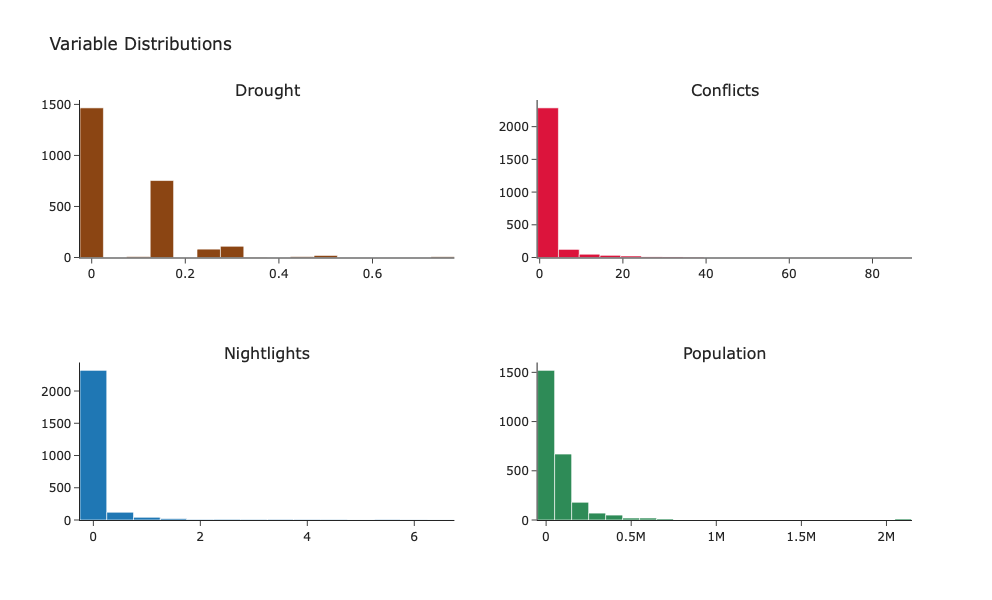

In [73]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Drought', 'Conflicts', 'Nightlights', 'Population'))

fig.add_trace(go.Histogram(x=df['droughtcrop_speibase'], nbinsx=30, name='Drought', marker_color='#8B4513'), row=1, col=1)
fig.add_trace(go.Histogram(x=df['conflicts'], nbinsx=30, name='Conflicts', marker_color='#DC143C'), row=1, col=2)
fig.add_trace(go.Histogram(x=df['nlights_mean'], nbinsx=30, name='Nightlights', marker_color='#1F77B4'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['pop_hyd_sum'], nbinsx=30, name='Population', marker_color='#2E8B57'), row=2, col=2)

fig.update_layout(height=600, showlegend=False, title_text="Variable Distributions")
fig.show()

- Boxplot for detecting outliers

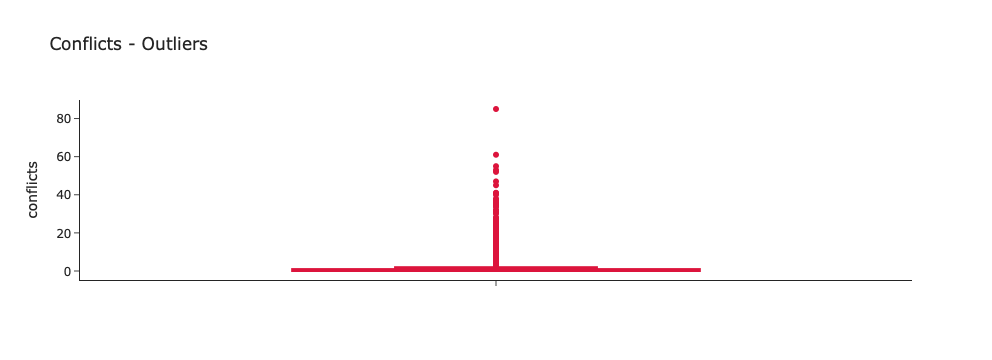

In [75]:
fig = px.box(df, y='conflicts', title='Conflicts - Outliers', color_discrete_sequence=['#DC143C'])
fig.show()

- Zero inflation and overdispersion for conflicts

In [77]:
zero_share = (df['conflicts'] == 0).mean()
mean_conf = df['conflicts'].mean()
var_conf = df['conflicts'].var()

print(f"Share of zero-conflict observations: {zero_share:%}")
print(f"Mean: {mean_conf:.2f}, Variance: {var_conf:.2f}")

Share of zero-conflict observations: 72.901961%
Mean: 1.75, Variance: 30.69


- **Interpretation**

Looking at the descriptive statistics and plots, I can see that all three main variables (drought, conflicts and nightlights) are right-skewed, most observations are clustered at low values, while a few extreme ones pull the mean to the right, creating a long tail.

Most cells have zero conflicts, zero nightlights, and little to no drought. That makes sense for a rural country like Afghanistan, light is scarce, violence is localized.

But the outliers tell a different story. The boxplot for conflicts shows cells with 10, 20, even 85 events. Nightlights too: median zero, but some cells hit 6.6. Drought reaches 0.75 while most sit at zero. So the real action isn't in the averages, it's in the extremes.

The numbers back this up. 75% of observations have at most one conflict and practically no light. Yet the maximums—85 conflicts, 6.6 nightlights—are orders of magnitude higher. Whatever is happening in those cells is exceptional. Maybe more developed areas attract conflict, or maybe conflict itself destroys light. Hard to say.

One last thing: 72.9% of cell‑years have zero conflicts, and the variance (30.7) is way larger than the mean (1.75). Statistically, that's 'zero‑inflated and overdispersed', fancy terms for 'rare events that vary wildly when they happen.' 

**2. Temporal Analysis**

Next, I looked at how things changed over time. Two charts helped with this:

A national trends line chart showing average drought, average nightlights and total conflicts per year. Good for spotting big picture patterns.

Boxplots by year for each variable. These show the full spread: medians, outliers and if the distribution shifts over time.

- National trends by year

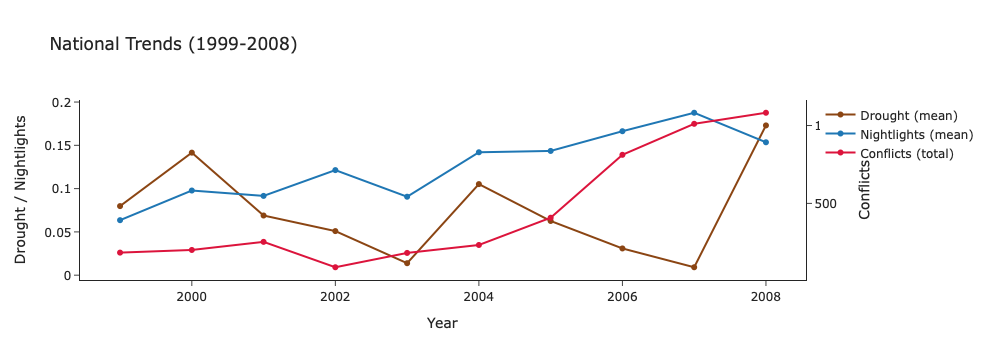

In [81]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=national['year'], y=national['droughtcrop_speibase'],
                         mode='lines+markers', name='Drought (mean)', line=dict(color='#8B4513')))
fig.add_trace(go.Scatter(x=national['year'], y=national['nlights_mean'],
                         mode='lines+markers', name='Nightlights (mean)', line=dict(color='#1F77B4')))
fig.add_trace(go.Scatter(x=national['year'], y=national['conflicts'],
                         mode='lines+markers', name='Conflicts (total)', line=dict(color='#DC143C'), yaxis='y2'))

fig.update_layout(
    title='National Trends (1999-2008)',
    xaxis_title='Year',
    yaxis=dict(title='Drought / Nightlights'),
    yaxis2=dict(title='Conflicts', overlaying='y', side='right'))
fig.show()

- Boxplots by year

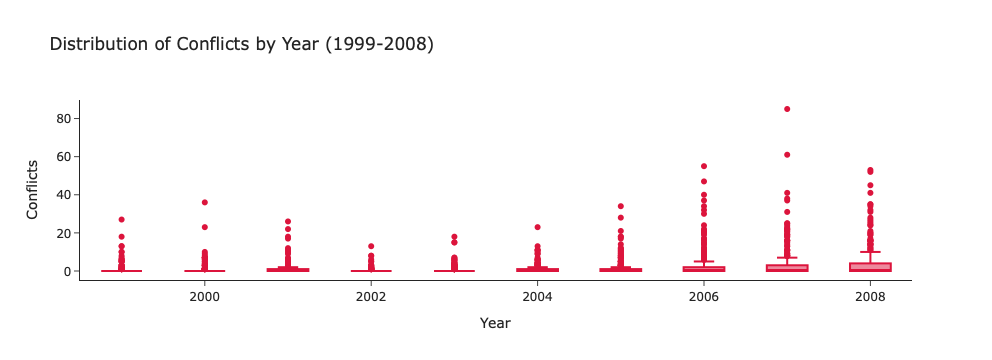

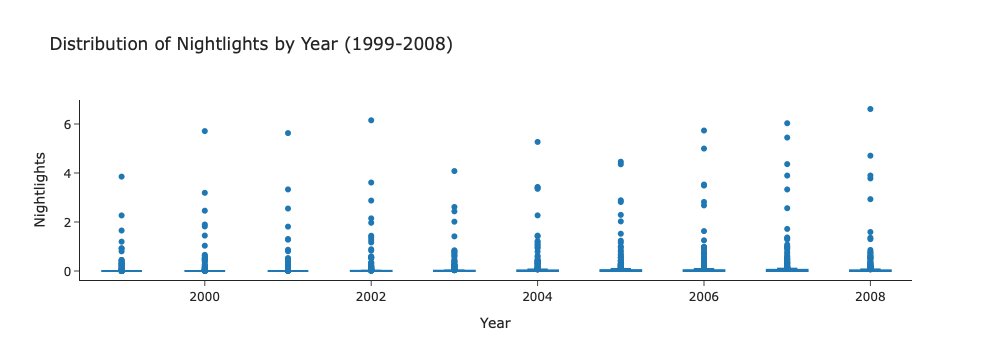

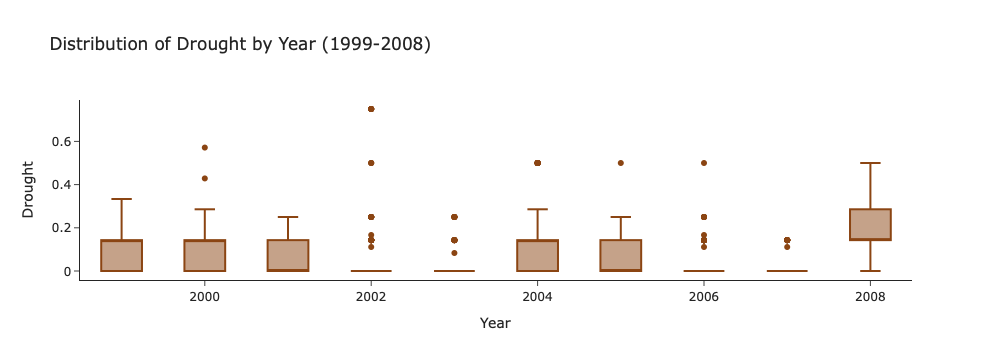

In [83]:
fig = px.box(df, x='year', y='conflicts', title='Distribution of Conflicts by Year (1999-2008)', color_discrete_sequence=['#DC143C'])
fig.update_layout(xaxis_title='Year', yaxis_title='Conflicts')
fig.show()

fig = px.box(df, x='year', y='nlights_mean', title='Distribution of Nightlights by Year (1999-2008)', color_discrete_sequence=['#1F77B4'])
fig.update_layout(xaxis_title='Year', yaxis_title='Nightlights')
fig.show()

fig = px.box(df, x='year', y='droughtcrop_speibase', title='Distribution of Drought by Year (1999-2008)', color_discrete_sequence=['#8B4513'])
fig.update_layout(xaxis_title='Year', yaxis_title='Drought')
fig.show()

- **Interpretation**

Conflicts: The median is zero every year, meaning most cells have no violence. But outliers tell they grow sharply after 2005, peaking in 2008 with cells reaching over 80 conflicts. Violence is rare, but when it happens, it's intense and concentrated.

Nightlights: Also zero for most cells, reflecting a rural country. Outliers increase steadily after 2002, likely reflecting international presence in cities. By 2008, some cells exceed 6 the decade's highest.

Drought: The three peak years (2000, 2004, 2008) stand out. In those years, more cells experience drought and values are higher. 2008 is especially striking, combining high drought with extreme violence.

Key findings: The same years that concentrate drought also concentrate violence. Nightlights grow throughout. Drought may act as a trigger, but it's clearly not the only factor. 2007, for instance, had high conflict despite very low drought.

**3. Spatial Analysis**

Interactive Plotly maps to explore the spatial patterns and distributions of variables in Afghanistan aggregated over the whole period (1999–2008). These maps use the same visual language as the dashboard (log‑scaled points, sequential color scales) and include hover information for each cell.

In [86]:
# aggregate total conflicts and mean drought per cell
cell_agg = df.groupby('gid').agg({
    'conflicts': 'sum',
    'droughtcrop_speibase': 'mean',
    'nlights_mean': 'mean',
    'lat': 'first',
    'lon': 'first',
    'geometry': 'first'}).reset_index()

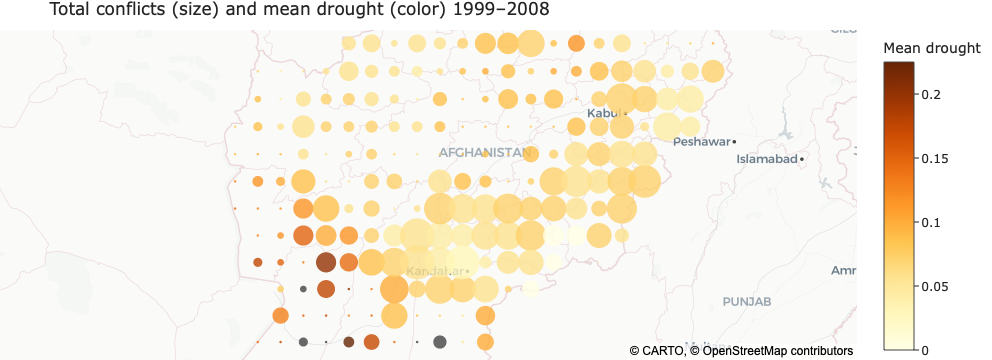

In [87]:
# pre‑compute point sizes for aggregated maps
cell_agg['marker_size'] = calculate_marker_size(cell_agg['conflicts'])

fig1 = go.Figure()

fig1.add_trace(go.Scattermap(
    lat=cell_agg['lat'],
    lon=cell_agg['lon'],
    mode='markers',
    marker=dict(
        size=cell_agg['marker_size'],
        color=cell_agg['droughtcrop_speibase'],
        colorscale='YlOrBr',
        showscale=True,
        colorbar=dict(title='Mean drought'),
        opacity=0.8,
        sizemode='diameter'),
    text=cell_agg['gid'].astype(str) +
         '<br>Total conflicts: ' + cell_agg['conflicts'].astype(str) +
         '<br>Mean drought: ' + cell_agg['droughtcrop_speibase'].round(3).astype(str),
    hoverinfo='text'))

fig1.update_layout(
    map=dict(
        style='carto-positron',
        center=dict(lat=33.0, lon=65.0),
        zoom=5),
    margin=dict(l=0, r=0, t=30, b=0),
    title='Total conflicts (size) and mean drought (color) 1999–2008')

fig1.show()

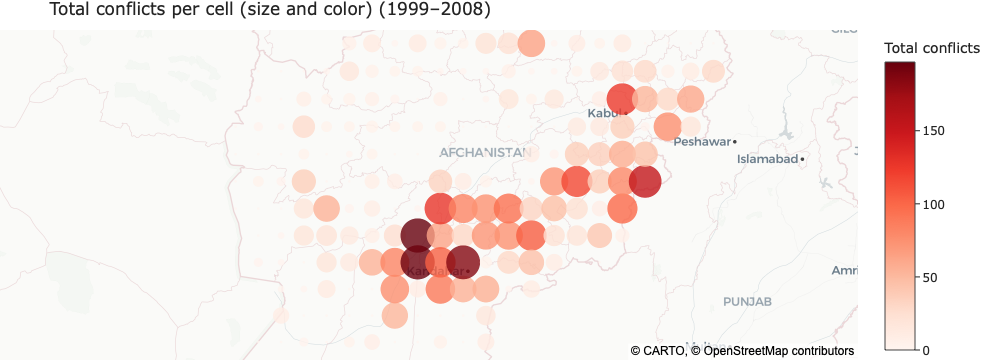

In [88]:
fig2 = go.Figure()

fig2.add_trace(go.Scattermap(
    lat=cell_agg['lat'],
    lon=cell_agg['lon'],
    mode='markers',
    marker=dict(
        size=cell_agg['marker_size'],
        color=cell_agg['conflicts'],
        colorscale='Reds',
        showscale=True,
        colorbar=dict(title='Total conflicts'),
        opacity=0.8,
        sizemode='diameter'),
    text=cell_agg['gid'].astype(str) +
         '<br>Total conflicts: ' + cell_agg['conflicts'].astype(str) +
         '<br>Mean drought: ' + cell_agg['droughtcrop_speibase'].round(3).astype(str),
    hoverinfo='text'))

fig2.update_layout(
    map=dict(
        style='carto-positron',
        center=dict(lat=33.0, lon=65.0),
        zoom=5),
    margin=dict(l=0, r=0, t=30, b=0),
    title='Total conflicts per cell (size and color) (1999–2008)')

fig2.show()

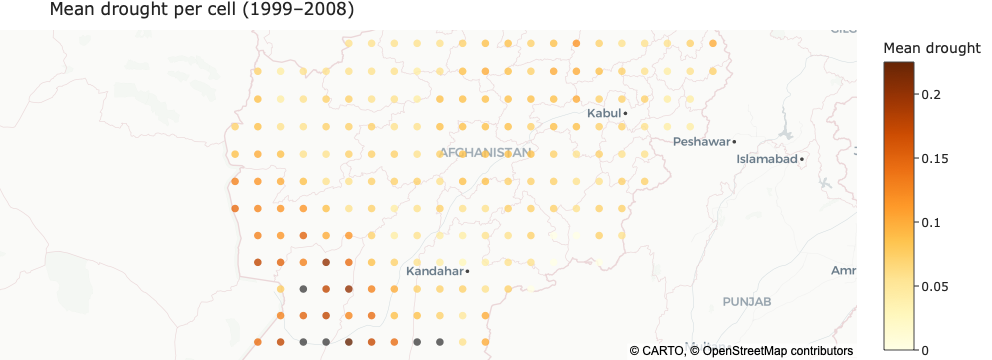

In [89]:
fig3 = go.Figure()

fig3.add_trace(go.Scattermap(
    lat=cell_agg['lat'],
    lon=cell_agg['lon'],
    mode='markers',
    marker=dict(
        size=8,   # fixed size
        color=cell_agg['droughtcrop_speibase'],
        colorscale='YlOrBr',
        showscale=True,
        colorbar=dict(title='Mean drought'),
        opacity=0.8,
        sizemode='diameter'),
    text=cell_agg['gid'].astype(str) +
         '<br>Mean drought: ' + cell_agg['droughtcrop_speibase'].round(3).astype(str),
    hoverinfo='text'))

fig3.update_layout(
    map=dict(
        style='carto-positron',
        center=dict(lat=33.0, lon=65.0),
        zoom=5),
    margin=dict(l=0, r=0, t=30, b=0),
    title='Mean drought per cell (1999–2008)')

fig3.show()

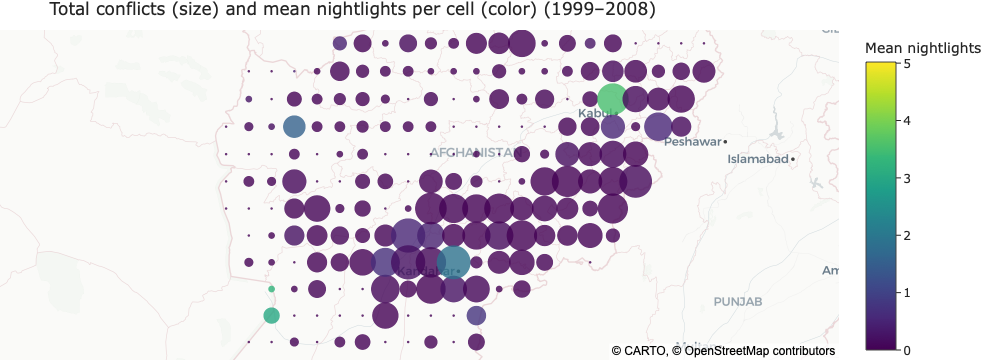

In [90]:
fig4 = go.Figure()

fig4.add_trace(go.Scattermap(
    lat=cell_agg['lat'],
    lon=cell_agg['lon'],
    mode='markers',
    marker=dict(
        size=cell_agg['marker_size'],  
        color=cell_agg['nlights_mean'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Mean nightlights'),
        opacity=0.8,
        sizemode='diameter'),
    text=cell_agg['gid'].astype(str) + 
         '<br>Total conflicts: ' + cell_agg['conflicts'].astype(str) +
         '<br>Mean nightlights: ' + cell_agg['nlights_mean'].round(3).astype(str),
    hoverinfo='text'))

fig4.update_layout(
    map=dict(
        style='carto-positron',
        center=dict(lat=33.0, lon=65.0),
        zoom=5),
    margin=dict(l=0, r=0, t=30, b=0),
    title='Total conflicts (size) and mean nightlights per cell (color) (1999–2008)')

fig4.show()

- **Interpretation**

Map 1: shows that large points (many conflicts) cluster in the south and east, the same areas with darker brown (higher drought). Northern regions have smaller points and lighter colours. So conflict and drought overlap spatially, especially in the rural south.

Map 2: confirms violence is highly regionalised: darkest red and largest points concentrate in the south and east, with isolated spots in the north (e.g. Kunduz). A small number of cells hold most of the conflict.

Map 3: shows drought is widespread, dark brown appears nearly in the south and west, but conflict only occurs where drought meets population and other drivers. Very dry but uninhabited areas (like the Registan desert) show no conflict.

Map 4: adds another layer: bright points (yellow/green) mark the few cities, Kabul, Kandahar, Herat. Some cities have large points (many conflicts) but most conflict areas are dark and rural. Violence happens both in lit cities and dark rural areas.

Taken together, these maps show that drought and conflict overlap in some regions, but drought alone never explains where violence happens. It's always drought and something else: population, location, other drivers.



**4. Multivariate Analysis**

- Correlation matrix (Spearman): because data is not normally distributed (lots of zeros, skewed values and outliers). A Pearson correlation would not be reliable.

- **Correlation matrix**

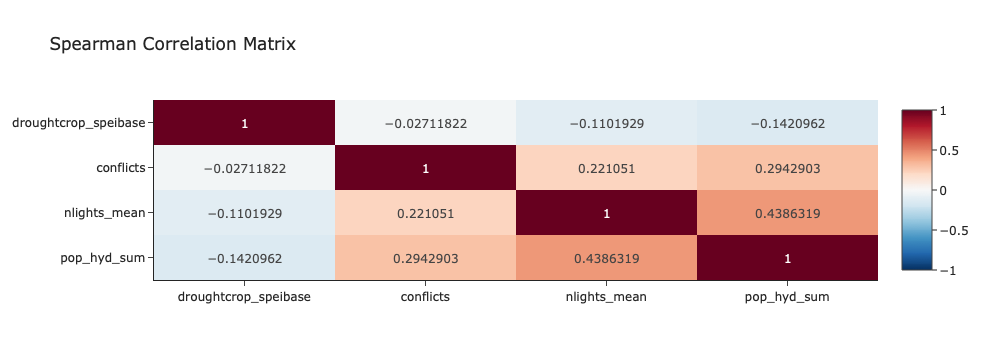

In [95]:
correlation = df[['droughtcrop_speibase', 'conflicts', 'nlights_mean', 'pop_hyd_sum']].corr(method='spearman')
fig = px.imshow(correlation, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r', range_color=[-1, 1],title='Spearman Correlation Matrix')
fig.show()

Drought and conflicts? (-0.03). That number confirms what we already saw: drought alone does not explain violence. Yes, 2008 was both dry and violent, but 2007 was violent with almost no drought. The overall pattern just is not there.

Conflicts and nightlights show a weak positive link (0.22). Cells with conflict tend to have slightly more light, not a strong pattern, but it suggests violence is not just about the poorest, darkest areas.

Conflicts and population (0.29) make sense: more people, more chance of conflict. But it is not a strong relationship either. conflict hotspots are often rural, not the most crowded places.

Nightlights and population (0.44) is the clearest connection. More people, more light. 

Drought with population or nightlights? (-0.11, -0.14). Drought happens where it happens, regardless of how many people live there.

- **Conflict presence and nightlights**

In [98]:
# Percentage of cells with nightlights > 0, by conflict presence
percentage_conflict_light = (conflict_cells['nlights_mean'] > 0).mean() * 100
percentage_nonconflict_light = (nonconflict_cells['nlights_mean'] > 0).mean() * 100

print(f"% conflict cells with light: {percentage_conflict_light:.1f}")
print(f"% nonconflict cells with light: {percentage_nonconflict_light:.1f}")

% conflict cells with light: 45.7
% nonconflict cells with light: 25.4


Cells with conflict are nearly twice as likely to have measurable nightlights (45.7% vs 25.4%). 

This supports the idea that violence is not limited to the poorest, darkest areas.

**4. Results/Summary Insights**

Insights from EDA:

- Highly skewed conflict distribution: A small number of grid cells account for a disproportionate share of total conflict events.

- Temporal escalation after 2005: Conflict intensity increases sharply from 2005 onwards.

- Moderate drought variability: Drought peaks in 2000, 2004, and 2008; 2007 shows low drought but high conflict.

- Economic concentration: Night-time light intensity is heavily concentrated; conflict likely to have non-zero light values.

- Correlation: Negligible drought‑conflict correlation; nightlights and population show a moderate positive link.

- Zero-inflation and overdispersion: Conflicts are zero-inflated and overdispersed, which will affect statistical modeling.

- Spatial concentration: Top 10 conflict cells contribute over 25% of total conflict events.

## 8. Interactive Dashboard

**Exploring Drought, Conflict and Night-Time Lights (1999–2008)**

This interactive dashboard explores the relationship between drought intensity, conflict and nightlights  activity in Afghanistan between 1999 and 2008.

The goal of this section is visualization and interactive exploration. The dashboard allows the user to move between national trends and local (cell-level) patterns and to dynamically select specific locations for deeper inspection.

**1. Interactive Map**

The map provides the spatial overview for a selected year. Each point represents one grid cell. Color shows drought intensity. Size reflects the number of conflicts (log-scaled to avoid distortion from extreme values).

Its main purpose is to identify geographical patterns:
Where are drought conditions strongest? Where are conflicts concentrated? Do they spatially overlap?

Clicking on a cell highlights it across other graphs, allowing focused analysis.

**2. National Trends (1999–2008)**

This graph provides the historical context. Left axis: average drought and nightlight time. Right axis: total number of conflicts. A vertical line marks the currently selected year.

Its purpose is to provide context. Instead of looking only at one year in isolation. 

**3. Scatter Plot (Selected Year)**

This plot focuses on relationships between variables at the cell level. X-axis: drought intensity. Y-axis: number of conflicts. Color: nightlight time. Each point represents one cell in the selected year

Its purpose is to visually explore if higher drought intensity is associated with higher conflict levels and how economic activity (night time lights) fits into that relationship.

**4. Violin Plot (Selected Year)**

This plot compares night time light levels between cells with conflict and without conflict. Beyond simple averages, the violin plot shows: The distribution shape, the spread and variability and the embedded boxplot statistics (median, quartiles).

Its purpose is to examine if economic activity differs systematically between peaceful and conflict-affected areas and whether differences are consistent or driven by outliers.


**Some design choices**

- Dot size: I used a logarithmic scale (log(conflicts+1)) so that cells with many conflicts do not visually overwhelm the ones with only a few.
- Two types of dots on the map: I split the data into cells with drought data (colored) and cells without (grey).
- Cell ID (gid): I store it in a special property (customdata) attached to every dot. When you click, Plotly hands that number directly, so there is no need to guess from indices. It is much more reliable.
- Resetting the selection box: Since I already add my own yellow highlight, I return None for clickData to remove Plotly's default rectangle and avoid visual confusion.

**How to interact**

- Move the year slider → all graphs update.

- Click any dot on the map or scatter → that cell turns yellow in every graph.

- The violin does not accept clicks (keeps the view clean), but when you select a cell elsewhere, it shows its position in the distribution.

In [157]:
# 1. Create the Dash app

app = Dash(__name__)


# 2. Layout of the dashboard, what the user sees

app.layout = html.Div([
    # Main title and short description of the dashboard
    html.H3("Drought vs Conflicts in Afghanistan (1999–2008)", 
            style={'text-align': 'center'}),
    html.P(
    "This dashboard allows users to explore possible relationships between drought and conflicts in Afghanistan (1999–2008)"
    ", including nightlights as an additional variable displayed alongside conflicts.",
    style={'text-align': 'center', 'font-style': 'normal', 'margin-bottom': '20px'}),
    html.P(
    "This dashboard supports exploratory analysis of spatial and temporal patterns. "
    "The visualisations highlight potential associations between variables but do not imply causality.",
    style={'text-align': 'center', 'font-style': 'italic', 'font-size': '13px', 'color': 'gray', 'margin-bottom': '20px'}),
    # Year slider
    html.Div([
        html.Label("Select year:"),
        dcc.Slider(
            id='year-slider',
            min=df['year'].min(),
            max=df['year'].max(),
            step=1,
            value=df['year'].min(),
            marks={str(y): str(y) for y in sorted(df['year'].unique())},
            tooltip={"placement": "bottom", "always_visible": True})
    ], style={'margin': '20px'}),

    # ROW 1: MAP
    html.Div([
        html.H4("Interactive Map", 
                style={'textAlign': 'center', 'marginBottom': '5px'}),
        dcc.Graph(id='map-graph', style={'height': '400px'}),
        html.Div([
            html.Span("● Point size: conflicts (log scale)", 
                      style={'fontSize':12, 'marginRight':'40px'}),
            html.Span("● Colors: yellow (low drought) to brown (high drought)", 
                      style={'fontSize':12})
        ], style={'textAlign': 'center', 'marginTop':'10px'})
    ], style={'width': '90%', 'padding': '5px', 'margin': '0 auto'}),

    # ROW 2: NATIONAL TRENDS
    html.Div([
        html.H4("National Trends: Drought, Nightlights and Conflicts (1999–2008)", 
                style={'textAlign': 'center', 'marginBottom': '2px'}),
        dcc.Graph(id='national-trends', style={'height': '400px'})
    ], style={'width': '70%', 'padding': '5px', 'margin': '0 auto'}),

    # ROW 3: SCATTER
    html.Div([
        html.H4("Drought vs Conflicts", 
                style={'textAlign': 'center', 'marginBottom': '5px'}),
        dcc.Graph(id='scatter-graph', style={'height': '400px'})
    ], style={'width': '70%', 'padding': '5px', 'margin': '0 auto'}),

    # ROW 4: VIOLIN 
    html.Div([
        html.H4("Nightlights by Conflict Presence", 
                style={'textAlign': 'center', 'marginBottom': '5px'}),
        dcc.Graph(id='violinplot-graph', style={'height': '400px'})
    ], style={'width': '70%', 'padding': '5px', 'margin': '0 auto'})
], style={'backgroundColor': '#f9f9f9', 'padding': '10px'})


# 3. Callback: updates all graphs when the year changes or a dot is clicked

@app.callback(
    # Outputs: four figures and two clickData resets (map and scatter)
    Output('map-graph', 'figure'),
    Output('scatter-graph', 'figure'),
    Output('violinplot-graph', 'figure'),
    Output('national-trends', 'figure'),
    Output('map-graph', 'clickData'),            # reset map click highlight
    Output('scatter-graph', 'clickData'),        # reset scatter click highlight
    # Inputs: the year slider and click events from the interactive graphs
    Input('year-slider', 'value'),
    Input('map-graph', 'clickData'),
    Input('scatter-graph', 'clickData')
)

# 4. The called function whenever the user moves the slider or clicks on any of the two graphs (map and scatter)
# It rebuilds all four figures based on the selected year and, if a dot was clicked, highlights that cell in other graphs

def update_graphs(selected_year, map_click, scatter_click):
    
    # 1. Prepare the data for the chosen year 
    
    df_year = df[df['year'] == selected_year].copy()
    df_year['marker_size'] = calculate_marker_size(df_year['conflicts'])

    # Cells with drought data get coloured by drought.
    # The rest (no drought data) are shown in grey.
    mask_valid = df_year['droughtcrop_speibase'].notna()
    df_valid = df_year[mask_valid].copy()
    df_grey = df_year[~mask_valid].copy()

    # This variable will hold the ID (gid) of the cell that the user clicked, if any.
    selected_gid = None

    
    # 2. Figure out which input triggered the callback and, if it was a click, extract the cell ID
    # ctx.triggered_id tells us the id of the input that caused this callback to run: 'year-slider' or 'map-graph' or 'scatter-graph' (or None)
    
    trig = ctx.triggered_id  
    # Use customdata to get the clicked cell ID. It's stored as a flat list of ints.
    # The user clicked on the map
    if trig == 'map-graph' and map_click:
        point = map_click['points'][0] 
        if 'customdata' in point and point['customdata'] is not None:
            selected_gid = int(point['customdata'])
                   
    # The user clicked on the scatter plot
    elif trig == 'scatter-graph' and scatter_click:
        point = scatter_click['points'][0]
        if 'customdata' in point and point['customdata'] is not None:
            selected_gid = int(point['customdata'])


    # 3. Build the map figure
    
    fig_map = go.Figure()
    
    # Trace 0: cells with valid drought data (coloured by drought intensity)
    if not df_valid.empty:
        fig_map.add_trace(go.Scattermapbox(
            lat=df_valid['lat'],
            lon=df_valid['lon'],
            mode='markers',
            marker=dict(size=df_valid['marker_size'], color=df_valid['droughtcrop_speibase'], colorscale='YlOrBr', 
                        showscale=True, colorbar=dict(title="Drought", x=1, y=0.5, len=0.8, thickness=15, 
                        bgcolor='rgba(255,255,255,0.8)'), opacity=1, sizemode='diameter'),
            # Hover text shows useful info
            text=df_valid.apply(lambda row: (
                f"GID: {row['gid']}<br>"
                f"Conflicts: {row['conflicts']}<br>"
                f"Drought: {row['droughtcrop_speibase']:.3f}<br>"
                f"Nightlights: {row['nlights_mean']:.3f}<br>"
                f"Population: {row['pop_hyd_sum']:.0f}"
            ), axis=1),
            hoverinfo='text',
            customdata=df_valid['gid'].astype(int).tolist(),   
            name='Cells with data'))
        
    # Trace 1: grey cells (no drought data)
    if not df_grey.empty:
        fig_map.add_trace(go.Scattermapbox(
            lat=df_grey['lat'],
            lon=df_grey['lon'],
            mode='markers',
            marker=dict(size=df_grey['marker_size'],         
                        color='lightgray', opacity=1, sizemode='diameter'),
            text=df_grey.apply(lambda row: (
                f"GID: {row['gid']}<br>"
                f"Conflicts: {row['conflicts']}<br>"
                f"Drought: {row['droughtcrop_speibase']:.3f}<br>"
                f"Nightlights: {row['nlights_mean']:.3f}<br>"
                f"Population: {row['pop_hyd_sum']:.0f}"), axis=1),
            hoverinfo='text',
            customdata=df_grey['gid'].astype(int).tolist(),   
            name='No drought data'))
        
    # Map layout: centre on Afghanistan
    fig_map.update_layout(mapbox=dict(style='carto-positron', center=dict(lat=33.0, lon=65.0), zoom=5),
                          margin=dict(l=0, r=0, t=0, b=0))
    
    # If a cell is selected, adds a bright yellow dot on top of it
    if selected_gid is not None:
        df_sel = df_year[df_year['gid'] == int(selected_gid)]
        if not df_sel.empty:
            fig_map.add_trace(go.Scattermapbox(
                lat=df_sel['lat'],
                lon=df_sel['lon'],
                mode='markers',
                marker=dict(size=float(df_sel['marker_size'].iloc[0]) + 12, color='yellow', opacity=0.9, sizemode='diameter'),
                hoverinfo='skip',    
                showlegend=False))

    # 4. National trends
    
    fig_trends = go.Figure()
    # Drought (left y-axis)
    fig_trends.add_trace(go.Scatter(x=national['year'], y=national['droughtcrop_speibase'], mode='lines+markers',
                                   name='Drought (mean)', yaxis='y1', line=dict(color='#8B4513', width=2)))
    # Nightlights (left y-axis)
    fig_trends.add_trace(go.Scatter(x=national['year'], y=national['nlights_mean'], mode='lines+markers',
                                   name='Nightlights (mean)', yaxis='y1', line=dict(color='#1F77B4', width=2)))
    # Conflicts (right y-axis, because scale is different)
    fig_trends.add_trace(go.Scatter(x=national['year'], y=national['conflicts'], mode='lines+markers',
                                   name='Conflicts (total)', yaxis='y2', line=dict(color='#DC143C', width=2.7)))
    # Vertical line for the currently selected year
    fig_trends.add_vline(x=selected_year, line_width=2, line_dash="dash", line_color="grey")
    fig_trends.update_layout(xaxis_title="Year",
                             yaxis=dict(title="Drought / Nightlights", color='black'),
                             yaxis2=dict(title="Conflicts", overlaying='y', side='right', color='#DC143C'),
                             hovermode='x unified', legend=dict(x=1.2, y=1, xanchor='left', yanchor='top'),
                             margin=dict(r=150))
               
        
    # 5. Scatter
    # Build scatter plot using go.Scatter for consistent customdata handling (flat list)
    
    fig_scatter = go.Figure()
    
    # Add main scatter trace (all cells)
    fig_scatter.add_trace(go.Scatter(
        x=df_year['droughtcrop_speibase'],
        y=df_year['conflicts'],
        mode='markers',
        marker=dict(size=df_year['marker_size'], color=df_year['nlights_mean'], colorscale='Viridis', 
                    showscale=True, colorbar=dict(title="Nightlights",  x=1.1, len=0.8, thickness=15), opacity=0.8, sizemode='diameter'),
        text=df_year.apply(lambda row: (
            f"GID: {row['gid']}<br>"
            f"Conflicts: {row['conflicts']}<br>"
            f"Drought: {row['droughtcrop_speibase']:.3f}<br>"
            f"Nightlights: {row['nlights_mean']:.3f}"), axis=1),
        hoverinfo='text',
        customdata=df_year['gid'].astype(int).tolist(),  # flat list of ints
        name='Cells'))
    
    # If a cell is selected, highlights it with a larger yellow dot
    if selected_gid is not None:
        df_sel = df_year[df_year['gid'] == int(selected_gid)]
        if not df_sel.empty:
            fig_scatter.add_trace(go.Scatter(
                x=df_sel['droughtcrop_speibase'],
                y=df_sel['conflicts'],
                mode='markers',
                marker=dict(size=float(df_sel['marker_size'].iloc[0]) + 12, color='yellow', opacity = 0.9,
                    sizemode='diameter'),
                hoverinfo='skip',
                showlegend=False))
    
    fig_scatter.update_layout(
        xaxis_title="Drought",
        yaxis_title="Conflicts",
        margin=dict(l=50, r=50, t=30, b=50))


    # 6. Violin (nightlights by conflict presence)
    
    df_year['has_conflict'] = df_year['conflicts'] > 0
    fig_violin = go.Figure()
    
    # Violin for cells with no conflicts
    if df_year[~df_year['has_conflict']]['nlights_mean'].notna().any():
        fig_violin.add_trace(go.Violin(y=df_year[~df_year['has_conflict']]['nlights_mean'],
                                       name="No conflict", box_visible=True, meanline_visible=True,
                                       line_color='#C0C0C0', fillcolor='#C0C0C0', opacity=0.6, points=False,  # hide individual points to keep the plot clean
                                       showlegend=False))
        
    # Violin for cells with conflicts
    if df_year[df_year['has_conflict']]['nlights_mean'].notna().any():
        fig_violin.add_trace(go.Violin(y=df_year[df_year['has_conflict']]['nlights_mean'],
                                       name="Conflict", box_visible=True, meanline_visible=True,
                                       line_color='#DC143C', fillcolor='#DC143C', opacity=0.6, points=False,
                                       showlegend=False))
        
    # If a cell is selected, put a yellow dot on the correct violin
    if selected_gid is not None:
        df_sel = df_year[df_year['gid'] == int(selected_gid)]
        if not df_sel.empty:
            category = "Conflict" if df_sel['has_conflict'].iloc[0] else "No conflict"
            fig_violin.add_trace(go.Scatter(x=[category], y=df_sel['nlights_mean'], mode='markers',
                                            marker=dict(color='yellow', size=14, opacity=0.9),
                                            hoverinfo='skip', showlegend=False))

    fig_violin.update_layout(yaxis_title="Nightlights", xaxis_title="", violingap=0, violinmode='overlay')

    # 7. Reset clickData to remove Plotly's default selection.
    # Our own yellow highlights already show the selection.
    # This tells Dash to forget the previous click and not draw the grey selection rectangle.
    
    reset_map = None
    reset_scatter = None

    # Return all four figures and the two clickData resets
    return fig_map, fig_scatter, fig_violin, fig_trends, reset_map, reset_scatter


# 5. Run the app, jupyter_mode='inline' for running inside the notebook, 'external' for outside

if __name__ == '__main__':
    app.run(debug=True, jupyter_mode='inline')

## 9. Discussion

**Interpretation**

When I started this project I wanted to see whether drought could help explain conflict patterns in Afghanistan between 1999 and 2008. 

After cleaning, exploring and connecting the data through interactive visualizations: conflict is extremely concentrated in a few cells and rises sharply after 2005, while drought shows peaks in some of the same years but does not consistently predict violence.

Also, areas with measurable nightlight time and higher population are more likely to experience conflict. In my sample, cells with conflict were nearly twice as likely to show some nightlight activity than peaceful cells. That suggests that violence is often associated with places of people, infrastructure or strategic value rather than with poverty alone.

The dashboard itself was key: linking map, scatter and violin plots let me move from national trends to single cells and check exceptions that simple aggregates hide. I made specific design choices (log scaling of marker size, separating valid vs grey traces, storing gid in customdata) to keep the visuals interpretable and the interactivity robust. 

In addition, I tried to apply basic Gestalt design principles, such as proximity, similarity and visual hierarchy, to ensure that the visualisations were readable and cognitively coherent. The goal was not only aesthetic clarity, but analytical clarity. Reducing cognitive overload so that relationships between drought, conflict, nightlights and population could be interpreted more reliably.

This work is exploratory. It documents patterns and raises hypotheses. Next steps would be modelling. For now, the main takeaway is that drought may matter in some contexts but it is not a dominant, standalone driver of conflict in this dataset.

**Limitations**

First, the data is aggregated at grid-cell level. This means that local variation within each cell is not captured. Conflict is highly uneven and summarising events per cell and year may hide smaller-scale dynamics that could be relevant.

Second, the population variable does not change over time in this dataset. This limits the ability to analyse demographic evolution and makes it difficult to assess if population growth played a role in the escalation of conflict after 2005.

Finally, nightlights were used as a proxy for economic activity or infrastructure. While this is common in  research, it remains an indirect indicator and should not be interpreted as a measure of wealth or governance capacity.

For these reasons, the findings of this project should be understood as exploratory rather than causal. Further modelling would be necessary to draw stronger conclusions.